In [2]:
import numpy as np
import multiprocessing as mp
from scipy.integrate import simps
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#%matplotlib inline

In [3]:
def keep_cleaning(on, off, threshold=3.0, verbose=False):
    """Compute residuals from data after clean component subtraction. 
    The rms and baseline is determined from the "offpulse" time series, 
    and the signal strength is calculated from the "onpulse" region.
    """
    rms = np.std(off)
    #median = np.median(off) # median is more reliable than mean
    mean = np.mean(off)
    
    datamax = np.max(on)

    #limit = median + threshold * rms
    limit = mean + threshold * rms
    
    if datamax > limit:
        #if verbose:
        #    print("Onpulse data maximum still above threshold")
        #    print("{0:g} > {1:g}".format(datamax, limit))
        return True
    else:
        if verbose:
            print("No more data are above the given threshold ({0}-sigma)".format(threshold))
            print("    data max.={0}".format(datamax))
            print("    threshold={0}".format(threshold * rms))
        return False

In [4]:
def gaussian(x, mu, sigma):
    gaus = (1 / (np.sqrt(2) * sigma)) * np.exp(-(x - mu)**2 / (2 * sigma**2))
    return gaus / gaus.max()

In [143]:
def thin_screen(x, tau, x0=0):
    t = x - x0
    h = (1 / tau) * np.exp(-t / tau)
    h[x <= x0] = 0
    
    return h

def thick_screen(x, tau, x0=0):
    t = x - x0
    h = np.sqrt((np.pi * tau) / (4 * t**3)) * np.exp(-tau * np.pi**2 / (16 * t))
    h[np.isnan(h)] = 0
    
    return h

def uniform_media(x, tau, x0=0):
    t = x - x0
    h = np.sqrt((np.pi**5 * tau**3) / (8 * t**5)) * np.exp(-tau * np.pi**2 / (4 * t))
    h[np.isnan(h)] = 0
    
    return h



In [6]:
def positivity(res, off_rms, m=1, x=1.5):
    
    U = np.zeros_like(res)
    # When the residual is less than x * rms, turn on the step-function.
    # This means that only those points that have been over subtracted (due to a poor choice in PBF)
    # contribute to this parameter
    U[res < x * off_rms] = 1 
    
    f_r = (m / (len(res) * off_rms**2)) * np.sum(U * res**2)
    
    return f_r
  
    
def skewness(ccs, nbins, dt=1):
    cc_times = dt * np.arange(0, len(ccs)) / float(nbins)
    
    # First moment, <t>, is required to calculate others
    av_t = np.sum(cc_times * ccs) / np.sum(ccs)
    # Second and third moments defined by: <x^n> = sum{ (ti - <t>)^n * Ci } / sum{ Ci }
    ensemble_3 = np.sum(ccs * (cc_times - av_t)**3) / np.sum(ccs)
    ensemble_2 = np.sum(ccs * (cc_times - av_t)**2) / np.sum(ccs)
    
    gamma = ensemble_3 / ensemble_2**(1.5)
    
    return gamma

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


2048 2048 2048 20480 2048


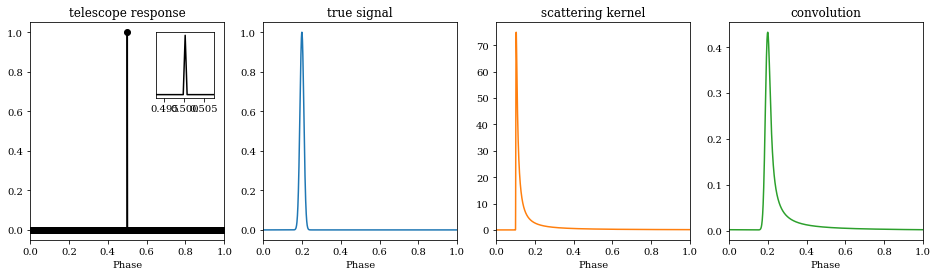

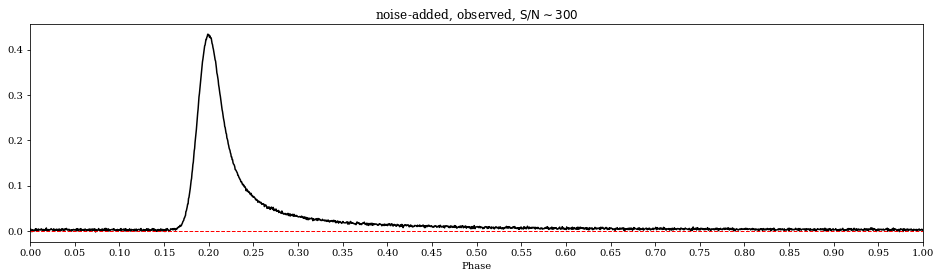

In [162]:
## Test deconvolution process
np.random.seed(11111)
nbins = 2048
nrot = 10
x = np.linspace(0, 1, nbins)
pbf_x = np.linspace(0, nrot, nrot*nbins)

# Create intrinsic pulse shape
f = np.zeros_like(x)
f += gaussian(x, x[x.size//5], 0.01)
#f += 0.1*gaussian(x, x[f.size//2+150], 0.02)
#f += 0.2*gaussian(x, x[f.size//2-150], 0.015)
#f += 0.5*gaussian(x, x[f.size//2-50], 0.005)
int_f = simps(y=f[:nbins], x=x)

# Create telescope impulse response function
response = np.zeros_like(f)
response[x.size//2] = 1.0 # i.e. assume response is a delta function
#response += gaussian(x, x[f.size//2], 0.0002)

# Create scattering kernel model
# use a much longer baseline to accurately capture the large-time behaviour of
# the PBF
tau = 0.01
x0 = 0.1
h = thick_screen(pbf_x, tau, x0)
#h = thick_screen(pbf_x, tau, x0)
#h = uniform_media(pbf_x, tau, x0)

# Create the observed pulse shape
# The observed pulse shape is the convlution of:
# - the true signal, 
# - the scattering kernel, and 
# - the telescope response (+ noise)
# Here we do the FULL convolution so that the complete shape is convlved 
# and we don't end up with sharp edge effects if using the "same" mode
g = np.convolve(f, h, mode="full") / np.sum(h)
g = np.convolve(g[:nrot*nbins], response, mode="full") / np.sum(response)
offset = np.argmax(f) - np.argmax(g)
g = np.roll(g, offset)[:nrot*nbins] # just take the bit we want (i.e. up to index nrot*nbins)

# now, split the convolved pulse (which is nrot rotations) into profiles of nbins
# and sum them to create the pulse profile.
# this mimics the idea of a periodic behaviour
g = np.sum(np.split(g, nrot), axis=0)


# Add approriate noise to give desired signal-to-noise ratio
snr = 300
data = np.copy(g) + np.random.normal(0, g.max() / snr, g.size)
data_init = np.copy(data)

print(data.size, response.size, f.size, h.size, g.size)
pbf_nrot_plot = 1



fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=plt.figaspect(0.25))

ax1.plot(x, response, color="k", marker="o")
ax1ins = inset_axes(ax1, width="30%", height="30%", borderpad=1)
ax1ins.plot(x, response, color="k")
ax1ins.set_xlim(x[np.argmax(response)-15], x[np.argmax(response)+15])
ax1ins.set_yticks([])

ax2.plot(x, f, color="C0")

ax3.plot(pbf_x, h, color="C1")

ax4.plot(x, g, color="C2")

ax1.set_title("telescope response")
ax1.set_xlabel("Phase")

ax2.set_title("true signal")
ax2.set_xlabel("Phase")

ax3.set_title("scattering kernel")
ax3.set_xlabel("Phase")

ax4.set_title("convolution")
ax4.set_xlabel("Phase")

ax1.set_xlim(0, 1)
ax2.set_xlim(0, 1)
ax3.set_xlim(0, pbf_nrot_plot)
ax4.set_xlim(0, 1)


fig, ax = plt.subplots(ncols=1, figsize=plt.figaspect(0.25))
ax.plot(x, data, color="k")
ax.axhline(0, color="r", ls="--", lw=1)
ax.set_title(r"noise-added, observed, $\rm S/N \sim {0}$".format(snr))
ax.set_xlabel("Phase")
ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.05, 0.05))

plt.show()

In [145]:
def clean(data, tau, results, dt=1, gain=0.01, pbftype="thin", iter_limit=None):
    
    nbins = len(data)
    nrot = 10
    x = np.linspace(0, 1, nbins) * dt
    pbf_x = np.linspace(0, nrot, nrot*nbins) * dt
    clean_components = np.zeros_like(data)
    
    if pbftype == "thin":
        filter_guess = thin_screen(pbf_x, tau)
    elif pbftype == "thick":
        filter_guess = thick_screen(pbf_x, tau)
    elif pbftype == "uniform":
        filter_guess = uniform_media(pbf_x, tau)
    else:
        print("Invalid PBF type requested ({0})".format(pbftype))
        return None
    
    delta = np.zeros(nbins)
    delta[delta.size//2] = 1.0
    
    profile = np.copy(data)
    
    loop = True
    niter = 0
    
    while loop:

        if (iter_limit is not None) and (niter >= iter_limit):
            print("Reacher iteration limit for tau={0:g}".format(tau))
            break
            
        imax = np.argmax(profile[on_lims[0]:on_lims[1]]) + on_lims[0]
        dmax = profile[imax]

        niter += 1

        temp_clean_comp = np.zeros_like(clean_components)
        temp_clean_comp[imax] = dmax * gain
        clean_components[imax] += dmax * gain

        rest_func = np.convolve(temp_clean_comp, delta, mode="same")
        rest_func = np.convolve(rest_func, filter_guess, mode="full")
        
        # normalise restoring function to make the multiplication/integration easier
        rest_func = rest_func / np.max(rest_func)

        # in this case, we have done the full convolution to accurately capture the shape of the PBF
        # and here we fold that so that it matches the profile data size and then subtract
        component = rest_func * temp_clean_comp[imax]
        offset = np.argmax(temp_clean_comp) - np.argmax(rest_func)
        component = np.roll(component, offset)[:nrot*nbins]
        component = np.sum(np.split(component, nrot), axis=0)

        cleaned = profile - component

        onpulse = cleaned[on_lims[0]:on_lims[1]]
        offpulse = np.concatenate((cleaned[:on_lims[0]], cleaned[on_lims[1]:]))

        loop = keep_cleaning(onpulse, offpulse, threshold=thresh)
        #if not loop:
        #    print("Reached noise floor after {0} iterations".format(niter))

        profile = np.copy(cleaned)
        plt.plot(profile)
    
    plt.show()
    
    n_unique = np.count_nonzero(clean_components)
    #print("Created {0} unique clean components".format(n_unique))
    offrms = np.std(offpulse)
    offmean = np.mean(offpulse)
    onrms = np.std(onpulse)
    nf = profile[(profile - offmean) <= 3 * offrms].size
    
    results.append(
                    dict(profile=profile, tau=tau, niter=niter, cc=clean_components, 
                        ncc=n_unique, nf=nf, off_rms=offrms, on_rms=onrms,
                        fr=positivity(profile, offrms),
                        gamma=skewness(clean_components, nbins, dt=dt)
                        )
    )

peak intensity=0.4344116901053958
rms=0.0014495910282653125
snr=299.6787932836787
on-pulse range=245:1843


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


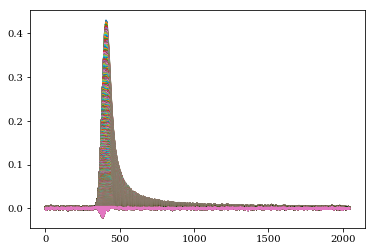

In [146]:
nbins = len(data_init)

gain = 0.01

onp1, onp2 = 0.12, 0.9
on_lims = np.array([int(onp1*nbins), int(onp2*nbins)])
onpulse = data[on_lims[0]:on_lims[1]]
offpulse = np.concatenate((data[:on_lims[0]], data[on_lims[1]:]))
init_rms = np.std(offpulse)

delta = np.zeros(nbins)
delta[delta.size//2] = 1.0

#plt.plot(offpulse)
#plt.show()

#plt.plot(data)
#plt.axvline(on_lims[0])
#plt.axvline(on_lims[1])


print("peak intensity={0}".format(onpulse.max()))
print("rms={0}".format(init_rms))
print("snr={0}".format(onpulse.max()/init_rms))
thresh = 3
print("on-pulse range={0}:{1}".format(on_lims[0], on_lims[1]))


results = []
taus = np.arange(0.01, 0.10, 0.01)
clean_kwargs = dict(dt=1, gain=0.01, pbftype="thick", iter_limit=10000)

t = tau
clean(data, t, results, **clean_kwargs)


#print("Performing CLEAN on {0} trial values".format(taus.size))
#with mp.Manager() as manager:
#    # create a list that can be seen by all processes
#    results = manager.list()
#    processes = []
#    
#    # spawn processes
#    for t in taus:
#        print("Spawning process to clean with tau={0:g}".format(t))
#        p = mp.Process(target=clean, args=(data, t, results), kwargs=clean_kwargs)
#        p.start()
#        processes.append(p)
#    
#    # combine them (wait for finish)
#    print("Waiting for processes to finish")
#    for p in processes:
#        p.join()
#    print("\tDone")
#    
#    # sort the results based on the trial value of tau
#    print("Sorting output...")
#    sorted_results = sorted(results, key=lambda r: r['tau'])
#    print("\tDone")






In [147]:
sorted_results = sorted(results, key=lambda r: r['tau'])

In [148]:
clean_profs = np.array([a["profile"] for a in sorted_results])
c = np.array([a["cc"] for a in sorted_results])
niter = np.array([a["niter"] for a in sorted_results])
ncc = np.array([a["ncc"] for a in sorted_results])
fr_vals = np.array([a["fr"] for a in sorted_results])
on_rms = np.array([a["on_rms"] for a in sorted_results])
off_rms = np.array([a["off_rms"] for a in sorted_results])
gamma_vals = np.array([a["gamma"] for a in sorted_results])
nf = np.array([a["nf"] for a in sorted_results])

In [ ]:
params = [fr_vals, gamma_vals, ncc, on_rms, off_rms/init_rms, nf]
labels = [r"$f_r$", r"$\Gamma$", r"$N_{cc}$", 
          r"$\sigma_{\rm on}$", r"$\sigma_{\rm offc}/\sigma_{\rm off}$", r"$N_f$"]

fig, axs = plt.subplots(ncols=3, nrows=2, sharex=True, figsize=(20,6))

for y, ylab, ax in zip(params, labels, axs.flatten()):
    ax.plot(taus, y, marker="o")
    ax.set_ylabel(ylab, fontsize=20)
    if min(y) < 0:
        ax.axhline(0, lw=1, ls=":", color="k")
    if abs(min(y)) > 0 and abs(max(y)/min(y)) > 100:
        ax.set_yscale("symlog")
    ax.axvline(tau, ls="--", color="r", label="truth")

for ax in axs.flatten()[3:]:
    ax.set_xlabel(r"$\tau$", fontsize=20)



#if abs(ncc.max()/ncc.min()) > 10:
#    ax3.set_yscale("log")
#    
#if abs(fr_vals.max()/fr_vals.min()) > 10:
#    ax1.set_yscale("log")
            
plt.tight_layout()
plt.show()





fig, axs = plt.subplots(ncols=3, nrows=int(np.ceil(c.shape[0]/3)), sharex=True, figsize=plt.figaspect(0.5))

for cc, t, ax in zip(c, taus, axs.flatten()):
    ax.plot(x, cc)
    ax.set_title(r"$\tau = {0:g}$".format(t))
    ax.set_yscale("symlog")
ax.set_xlim(onp1, onp2)

for ax in axs.flatten()[(axs.shape[0]-1)*axs.shape[1]:]:
    ax.set_xlabel("Phase")
    
for ax in axs.flatten()[::axs.shape[0]]:
    ax.set_ylabel("CC amplitudes")
    
plt.tight_layout()
plt.show()

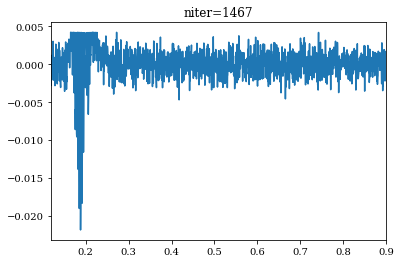

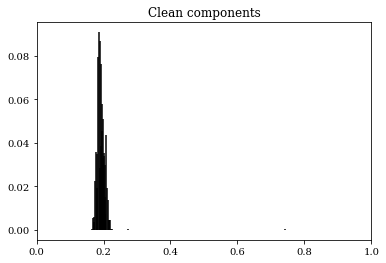

number of unique clean components created=38
total clean components added=1467
model offet=-213
mean res. = -0.002957537444019097
rms res. = 0.05724326840796805


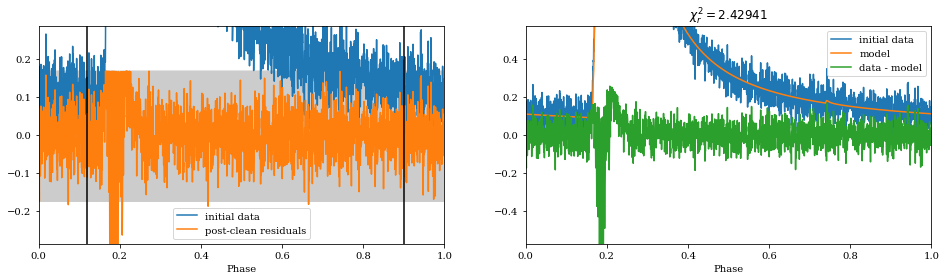

In [159]:
idx = 0
residuals = clean_profs[idx]
clean_components = c[idx]

plt.plot(x, residuals)
plt.title("niter={0}".format(niter[idx]))
plt.xlim(onp1, onp2)
plt.show()

plt.vlines(x, ymin=0, ymax=clean_components, color="k")
plt.xlim(0, 1)
plt.title("Clean components")
plt.show()

print("number of unique clean components created={0}".format(np.count_nonzero(clean_components)))
print("total clean components added={0}".format(niter[idx]))

model = np.convolve(clean_components, h, mode="full") / np.sum(h)
model_offset = np.argmax(data_init) - np.argmax(model)
# TODO: This probably isn't actually the correct way to do this, since for noisy data, 
# the peak intensity doesn't necessarily correspond to the maximum emission peak,
# more the combination of noise and emission. You could consider doing a quick 
# correlation analysis of the model and data to figure out the optimal alignment.
print("model offet={0}".format(model_offset))
model = np.roll(model, model_offset)[:nrot*nbins]
# TODO: How the heck do I normalise the model to match the data? 
# There must be some natural way that falls out of the convolution idea...
model = np.sum(np.split(model, nrot), axis=0)




# For easier comparison, normalise everything to have unit area
r = residuals / simps(x=x, y=data_init)
d = data_init / simps(x=x, y=data_init)
m = model / simps(x=x, y=model)

offpulse = np.concatenate((r[:on_lims[0]], r[on_lims[1]:]))
mean_offpulse = np.mean(offpulse)
rms_offpulse = np.std(offpulse)
print("mean res. = {0}".format(mean_offpulse))
print("rms res. = {0}".format(rms_offpulse))
upper = mean_offpulse + thresh*rms_offpulse
lower = mean_offpulse - thresh*rms_offpulse

#nmodel = data_init.max() * model/model.max()
rcs = np.sum((d - m)**2 / rms_offpulse**2) / data_init.size

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=plt.figaspect(0.25))
ax1.plot(x, d, label="initial data")
ax1.plot(x, residuals / simps(x=x, y=data_init), label="post-clean residuals")
ax1.fill_between(np.linspace(0, len(m)-1, len(m)), lower, upper, color="0.8")
ax1.axvline(onp1, color="k")
ax1.axvline(onp2, color="k")
#ax1.set_yscale("symlog")
ax1.set_xlabel("Phase")
ax1.set_ylim(-5 * rms_offpulse, 5 * rms_offpulse)
ax1.legend()

ax2.plot(x, d, label="initial data")
ax2.plot(x, m, label="model")
ax2.plot(x, d - m, label="data - model")
#ax2.plot(x, residuals / simps(x=x, y=data_init), label="post-clean residuals")
#ax2.set_yscale("symlog")
ax2.set_ylim(-10 * rms_offpulse, 10 * rms_offpulse)
ax2.set_xlabel("Phase")
ax2.set_title(r"$\chi^2_r = {0:g}$".format(rcs))
ax2.legend()

plt.xlim(0, 1)
plt.show()

corr offset = -87
true offset = -85
data offset = -87


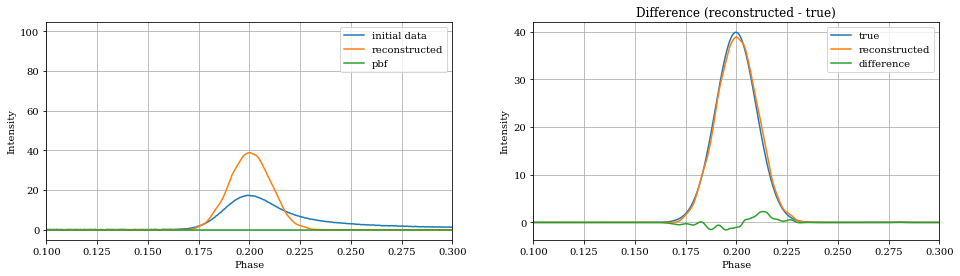

In [160]:
# Do the reconstruction
#TDOD: How do I normalise data throughout so that we get sensible reconstructed amplitudes
g_resp = np.zeros_like(residuals)
g_resp += gaussian(x, x[100], 0.002)
g_resp = g_resp / g_resp.max()



rc = np.convolve(clean_components, g_resp, mode="full")[:nbins]
true_offset = np.argmax(f) - np.argmax(rc)
corr_offset = -(nbins-np.argmax(np.correlate(f, rc, mode="full")))
print("corr offset =", corr_offset)
print("true offset =", true_offset)
data_offset = np.argmax(data_init) - np.argmax(rc)
print("data offset =", data_offset)
rc = np.roll(rc, true_offset)

rc = rc / simps(x=x, y=rc)
true = f / simps(x=x, y=f)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=plt.figaspect(0.25))

ax1.plot(x, d, label="initial data")
ax1.plot(x, rc, label="reconstructed")
ax1.plot(x, thin_screen(x, tau, x0=0.36), label="pbf")
ax1.grid(True)
ax1.set_xlabel("Phase")
ax1.set_ylabel("Intensity")
ax1.legend()

ax2.plot(x, true, label="true")
ax2.plot(x, rc, label="reconstructed")
ax2.plot(x, rc - true, label="difference")
ax2.set_title("Difference (reconstructed - true)")
#ax2.set_yscale("symlog")
ax2.grid(True, which="both")
ax2.set_xlabel("Phase")
ax2.set_ylabel("Intensity")
ax2.legend()

plt.xlim(onp1, onp2)
plt.xlim(0.1, 0.3)
plt.show()